Let's get a full cycle estimate for each protonation state we are sampling. We'll also need to calculate analytically the cost of the restraint on the ion in solution, which will also let us take into account the standard state. For each state we should do brief convergence checks.

In [1]:
import alchemlyb

In [2]:
import mdsynthesis as mds
from dask.delayed import delayed
import os.path
import pandas as pd

from alchemlyb.preprocessing import slicing
from alchemlyb.parsing.gmx import extract_dHdl

from dask.distributed import Client, LocalCluster

In [3]:
T = 310
k_b = 8.3144621E-3

### YOU CAN RUN THE CELL AT THE BOTTOM OF THE NEXT SECTION TO BYPASS ALL OF THIS IF YOU WOULD LIKE

## Analytic removal of restraint

We need to calculate the cost of removing the restraint, but it is not really possible to get this from simulation results. We can, however, get this analytically. We need to obtain:

$$ \Delta G_r = -kT \ln{\frac{Z_P Z_L}{Z_{CL}}} $$

where $Z_P$ is the partition function of the protein, which in general we cannot calculate, $Z_L$ is the partition function of the free ligand (noninteracting with the protein or the rest of the system), and $Z_{CL}$ is the partition function of the protein + restrained ligand. For $\Delta G_r$ to be easily calculable, then $Z_{CL}$ must be separable like:

$$ Z_{CL} = Z_P \times Z_r \times \tilde{Z_L} $$

Where $Z_r$ is the partition function of the restraint itself, and $\tilde{Z_L}$ is the partition function of the internal degrees of freedom of the ligand. For a point particle, this is $\tilde{Z_L} = 1$. The reason this is $\tilde{Z_L}$ and not $Z_L$ is because external degrees of freedom for the ligand are accounted for in the protein and the restraint. Also, note then:

$$ Z_L = V \tilde{Z_L} $$

since the partition function for the external degrees of freedom of a noninteracting point particle is simply the volume of the space it can explore.

So for $\Delta G$ we get:

$$ \Delta G_r = -kT \ln{\frac{Z_P Z_L}{Z_P Z_r \tilde{Z_L}}} = -kT \ln{\frac{V}{Z_r}} $$

and so we only need $Z_r$, which we can at least express analytically:

$$ Z_r = \int_{0}^{2\pi}\int_{0}^{\pi}\int_{0}^{\infty} dr\,r\,d\theta\,r\,\sin(\theta)\,d\phi\,e^{-\beta (U_{\theta}(\vec{r}) + U_r(\vec{r}))} $$
$$ Z_r = 2\pi \int_{0}^{\pi} e^{-\beta U_{\theta}(\theta)}\,\sin(\theta)\,d\theta \, \int_{0}^{\infty} r^2\,e^{-\beta U_r(r)}\,dr $$

And where we have for the restraints:

$$ U_{\theta}(\theta) = \frac{1}{2} k_{\theta} (\theta - \theta_0)^2 $$
$$ U_{r}(r) = \frac{1}{2} k_{r} (r - r_0)^2 $$

In [4]:
import sympy
sympy.init_printing(use_unicode=True)

In [5]:
r, theta, k_r, k_theta, r_0, theta_0, beta, V = sympy.symbols('r theta k_r k_theta r_0 theta_0 beta V')

In [6]:
subs = {k_theta: 23.0,
        k_r: 16000.0,
        r_0: 0.275,
        theta_0: 0.0,
        beta : 1/(8.3144621E-3 * 310),
        V: 1.6605778811026237}  # standard volume in nm^3

The $\theta$ integral:

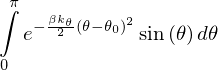

In [7]:
f_theta = sympy.exp(-(beta * k_theta/2) * (theta - theta_0)**2 ) * sympy.sin(theta)
Z_rtheta = sympy.Integral(f_theta, (theta, 0, sympy.pi))
Z_rtheta

In [8]:
Z_rtheta.subs(subs).evalf()

The $r$ integral:

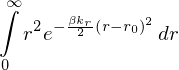

In [9]:
f_r = sympy.exp(-(beta * k_r/2) * (r - r_0)**2 ) * r**2
Z_rr = sympy.Integral(f_r, (r, 0, sympy.oo))
Z_rr

In [10]:
Z_rr.subs(subs).evalf()

So we get for $Z_r$:

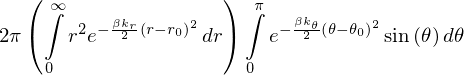

In [11]:
Z_r = 2 * sympy.pi * Z_rtheta * Z_rr
Z_r

In [12]:
Z_r.subs(subs).evalf()

And therefore $\Delta G_r$ is:

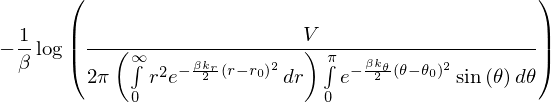

In [13]:
DG_r = - 1/beta * sympy.ln(V/Z_r)
DG_r

In [15]:
DG_r_unbind = DG_r.subs(subs).evalf()
DG_r_unbind

In [94]:
DG_r_unbind = -17.8435335231149 # why keep computing the same thing

# Free energy difference from data

We now need to define a couple of functions that will make our analysis cleaner.

In [17]:
def get_dHdl_XVG(sim, lower=None, upper=None, step=None):
    dHdls = []
    for xvg in sim['WORK/dhdl/'].glob('*.xvg'):
        dHdls.append(extract_dHdl(xvg.abspath, T=T))
    return slicing(pd.concat(dHdls).sort_index(0), 
                   lower=lower, 
                   upper=upper, 
                   step=step)

This function will collect the dHdl data from a sim, which should contain multiple XVG files

In [18]:
def get_dHdl(sim, lower=None, upper=None, step=None):
    try:
        dHdl = sim.data.retrieve('dHdl')
        
        if dHdl is None:
            dHdl = get_dHdl_XVG(sim, lower=lower, upper=upper, step=step)

        
        dHdl = slicing(dHdl.sort_index(0), 
                       lower=lower, 
                       upper=upper, 
                       step=step)
    except:
        # THIS WILL NOT STORE THE VALUE FOR LATER USE SO YOU SHOULD REALLY
        # CONTINUOUSLY UPDATE THE dHdl DATA IN THE SIMS
        dHdl = get_dHdl_XVG(sim, lower=lower, upper=upper, step=step) 
    
    return dHdl

Given a sim, we would like to know if we have already stored the processed XVG data in the sim's data. If not, then we need to extract it using the the function at the top of this section.

In [30]:
from alchemlyb.estimators import TI

def get_TI(dHdl):
    ti = TI().fit(dHdl)
    df = pd.DataFrame({'DG': k_b * T * ti.delta_f_.values[0,-1:], 
                       'std': k_b * T * ti.d_delta_f_.values[0,-1:]},
                      columns=['DG', 'std'])

    return df

Provided that we have the dHdl data, we should in principle be able to compute the free energy difference between our two end states.

With these functions, we should be able to build the final binding free energy for our different states.

In [23]:
cl = Client()

# Ion in solution

We want to collect the free energies for the legs of the ion in solution.

Collect all of the sims, i.e. 2 groups of $\lambda$ windows

In [31]:
ionsegs = {'repulsion_to_ghost': mds.discover('/nfs/homes3/dldotson/Projects/Transporters/SYSTEMS/Na/repulsion_to_ghost/production1/'),
           'ghost_to_ion': mds.discover('/nfs/homes3/dldotson/Projects/Transporters/SYSTEMS/Na/ghost_to_ion/production1/')}

We then iterate over each group of windows and create a list of the dHdl dataframes that are then concatenated. The concatenated dataframes are then used in the TI estimator from alchemlyb.

In [32]:
dHdls = {}
for seg in ionsegs:
    dHdls[seg] = [delayed(get_dHdl, pure=True)(sim, lower=5000, step=200)
                                for sim in ionsegs[seg]]

In [33]:
L_ionDG = {}
for seg in ionsegs:
    iondg_d = delayed(get_TI)(delayed(pd.concat)(dHdls[seg]))
    L_ionDG[seg] = cl.compute(iondg_d)

In [34]:
ionDG = cl.gather(L_ionDG)

The resulting values for each group are then accumulated

In [35]:
dfs = []
for seg in ionDG:
    df = ionDG[seg]
    df['segment'] = seg
    dfs.append(df)

In [36]:
ionDG = pd.concat(dfs)

In [37]:
ionDG = ionDG.set_index('segment')

The `ghost_to_ion` leg was calculated in the reverse direction, so we should put a negative sign on it.

In [38]:
ionDG.loc['ghost_to_ion', 'DG'] = -1 * ionDG.loc['ghost_to_ion', 'DG']

In [39]:
ionDG

,DG,std
segment,,
ghost_to_ion,-374.104072,0.216224
repulsion_to_ghost,-0.247003,0.008093


The process shown above is general and can be used for any FEP dataset. The next section will be more a more complicated version of this.

The final binding free energy value depends on this intermediate value.

# Complex + ion

This is where a large amount of data need to be read in. In the simplest case, we would only include one of the below groups in the `segs` dictionary.

In [40]:
topdir = mds.Tree('/nfs/homes4/workflows/Projects/Transporters/NapA/SYSTEMS/ionbinding/na/')

In [41]:
segs_s2if = {'unrestrained_to_restrained': mds.discover(topdir['if/S2/unrestrained_to_restrained/production1']),
             'restrained_to_repulsion': mds.discover(topdir['if/S2/restrained_to_repulsion/production1/']),
             'repulsion_to_ghostrepulsion': mds.discover(topdir['if/S2/repulsion_to_ghostrepulsion/production1/'])}

In [42]:
segs_s4if = {'unrestrained_to_restrained': mds.discover(topdir['if/S4/unrestrained_to_restrained/production1']),
             'restrained_to_repulsion': mds.discover(topdir['if/S4/restrained_to_repulsion/production1/']),
             'repulsion_to_ghostrepulsion': mds.discover(topdir['if/S4/repulsion_to_ghostrepulsion/production1/'])}

In [43]:
segs_s2of = {'unrestrained_to_restrained': mds.discover(topdir['of/S2/unrestrained_to_restrained/production1']),
             'restrained_to_repulsion': mds.discover(topdir['of/S2/restrained_to_repulsion/production1/']),
             'repulsion_to_ghostrepulsion': mds.discover(topdir['of/S2/repulsion_to_ghostrepulsion/production1/'])}

In [44]:
segs_s4of = {'unrestrained_to_restrained': mds.discover(topdir['of/S4/unrestrained_to_restrained/production1']),
             'restrained_to_repulsion': mds.discover(topdir['of/S4/restrained_to_repulsion/production1/']),
             'repulsion_to_ghostrepulsion': mds.discover(topdir['of/S4/repulsion_to_ghostrepulsion/production1/'])}

In [45]:
segs = {'s2if': segs_s2if,
        's4if': segs_s4if,
        's2of': segs_s2of,
        's4of': segs_s4of}

#### Using all data

In [47]:
L_DG = {} 

for state in segs:
    ddgs = {}
    for seg in segs[state]:
        dHdls = delayed(pd.concat)([delayed(get_dHdl)(sim, lower=5000, step=200)
                                    for sim in segs[state][seg]])
        ddgs[seg] = delayed(get_TI)(dHdls)
    
    L_DG[state] = {seg: cl.compute(ddgs[seg]) for seg in segs[state]}

In [48]:
DG = cl.gather(L_DG)

In [49]:
DG

{'s2if': {'repulsion_to_ghostrepulsion':            DG       std
  0  434.785893  0.067915, 'restrained_to_repulsion':          DG       std
  0 -0.008853  0.002109, 'unrestrained_to_restrained':          DG       std
  0  2.362626  0.027201},
 's2of': {'repulsion_to_ghostrepulsion':            DG       std
  0  419.959237  0.067933, 'restrained_to_repulsion':         DG       std
  0  0.00009  0.000064, 'unrestrained_to_restrained':          DG       std
  0  3.159437  0.065445},
 's4if': {'repulsion_to_ghostrepulsion':            DG       std
  0  479.045975  0.072704, 'restrained_to_repulsion':          DG       std
  0  0.000371  0.000102, 'unrestrained_to_restrained':           DG       std
  0  11.761585  0.047235},
 's4of': {'repulsion_to_ghostrepulsion':            DG       std
  0  421.070558  0.069138, 'restrained_to_repulsion':          DG       std
  0 -0.000058  0.000207, 'unrestrained_to_restrained':           DG       std
  0  13.293795  0.189712}}

## S2 IF

In [50]:
state = 's2if'

In [51]:
dfs = []
for seg in DG[state]:
    df = DG[state][seg]
    df['segment'] = seg
    dfs.append(df)

In [52]:
dfDG = pd.concat(dfs)

In [53]:
dfDG = dfDG.set_index('segment')

In [54]:
order = ['unrestrained_to_restrained', 
         'restrained_to_repulsion',
         'repulsion_to_ghostrepulsion']

In [55]:
dfDG = dfDG.loc[order]

In [56]:
dfDG

,DG,std
segment,,
unrestrained_to_restrained,2.362626,0.027201
restrained_to_repulsion,-0.008853,0.002109
repulsion_to_ghostrepulsion,434.785893,0.067915


In [57]:
pd.concat([dfDG, ionDG])['DG'].sum()

In [58]:
std = pd.np.sqrt((pd.concat([dfDG, ionDG])['std'] **2).sum())
std

In [60]:
var = std**2
var

In [61]:
DG_unbind = (pd.concat([dfDG, ionDG])['DG'].sum() + DG_r_unbind)
DG_unbind

Here we have calculated the unbinding free energy in the S2 IF state. So the binding free energy is the negative of the value shown. The rest of the calculations are effectively repeats of this protocol.

## S4 IF

In [63]:
state = 's4if'

In [64]:
dfs = []
for seg in DG[state]:
    df = DG[state][seg]
    df['segment'] = seg
    dfs.append(df)

In [65]:
dfDG = pd.concat(dfs)

In [66]:
dfDG = dfDG.set_index('segment')

In [67]:
order = ['unrestrained_to_restrained', 
         'restrained_to_repulsion',
         'repulsion_to_ghostrepulsion']

In [68]:
dfDG = dfDG.loc[order]

In [70]:
dfDG

,DG,std
segment,,
unrestrained_to_restrained,11.761585,0.047235
restrained_to_repulsion,0.000371,0.000102
repulsion_to_ghostrepulsion,479.045975,0.072704


In [71]:
pd.concat([dfDG, ionDG])['DG'].sum()

In [72]:
pd.np.sqrt((pd.concat([dfDG, ionDG])['std'] **2).sum())

In [73]:
DG_unbind = (pd.concat([dfDG, ionDG])['DG'].sum() + DG_r_unbind)
DG_unbind

## S2 OF

In [74]:
state = 's2of'

In [75]:
dfs = []
for seg in DG[state]:
    df = DG[state][seg]
    df['segment'] = seg
    dfs.append(df)

In [76]:
dfDG = pd.concat(dfs)

In [77]:
dfDG = dfDG.set_index('segment')

In [78]:
order = ['unrestrained_to_restrained', 
         'restrained_to_repulsion',
         'repulsion_to_ghostrepulsion']

In [79]:
dfDG = dfDG.loc[order]

In [80]:
dfDG

,DG,std
segment,,
unrestrained_to_restrained,3.159437,0.065445
restrained_to_repulsion,0.000090,0.000064
repulsion_to_ghostrepulsion,419.959237,0.067933


In [81]:
pd.concat([dfDG, ionDG])['DG'].sum()

In [82]:
pd.np.sqrt((pd.concat([dfDG, ionDG])['std'] **2).sum())

In [83]:
DG_unbind = (pd.concat([dfDG, ionDG])['DG'].sum() + DG_r_unbind)
DG_unbind

## S4 OF

In [84]:
state = 's4of'

In [85]:
dfs = []
for seg in DG[state]:
    df = DG[state][seg]
    df['segment'] = seg
    dfs.append(df)

In [86]:
dfDG = pd.concat(dfs)

In [87]:
dfDG = dfDG.set_index('segment')

In [88]:
order = ['unrestrained_to_restrained', 
         'restrained_to_repulsion',
         'repulsion_to_ghostrepulsion']

In [89]:
dfDG = dfDG.loc[order]

In [90]:
dfDG

,DG,std
segment,,
unrestrained_to_restrained,13.293795,0.189712
restrained_to_repulsion,-0.000058,0.000207
repulsion_to_ghostrepulsion,421.070558,0.069138


In [91]:
pd.concat([dfDG, ionDG])['DG'].sum()

In [92]:
pd.np.sqrt((pd.concat([dfDG, ionDG])['std'] **2).sum())

In [93]:
DG_unbind = (pd.concat([dfDG, ionDG])['DG'].sum() + DG_r_unbind)
DG_unbind